In [1]:
import sys
from pathlib import Path
path_root = '../'
sys.path.append(str(path_root))

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from one.api import ONE
from brainbox.io.one import SessionLoader, SpikeSortingLoader
from iblatlas.atlas import AllenAtlas
from utils.ibl_data_utils import (
    load_spiking_data, load_trials_and_mask, merge_probes,
    load_trial_behaviors, load_anytime_behaviors,
    prepare_data, 
    select_brain_regions, list_brain_regions, 
    bin_spiking_data, 
)
from utils.dataset import create_dataset, upload_dataset, download_dataset, get_binned_spikes_from_sparse

/home/berk/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/neurodsp/__init__.py:5: FutureWarning: neurodsp has been renamed to ibldsp and the old name will be deprecated on 01-Sep-2024.
  warn(
/home/berk/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Data Loading Example (Single Session)

In [2]:
# Instantiate ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', 
          silent=True, 
        #   cache_dir='/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
)
one = ONE(password='international')
ba = AllenAtlas()

In [3]:
# List all publicly available sessions
# sessions = one.search()

# List all sessions from the brain-wide-map project
# Note: Not all sessions will have behaviors recorded so we can use sessions 
#       w/ behaviors for supervised tasks and those w/o for SSL
# sessions = one.search(project='brainwide')

# List brainwide map sessions that pass the most important quality controls
# Note: Let's first work with these good quality sessions, and 
#       transition to using more sessions later on
freeze_file = '../data/2023_12_bwm_release.csv'
bwm_df = pd.read_csv(freeze_file, index_col=0)

In [4]:
# Load an example session
idx = 400
pid = bwm_df.pid[idx]
eid, probe = one.pid2eid(pid)

In [5]:
# Load spike sorting data
spikes, clusters = load_spiking_data(one, pid)

In [6]:
# We may not want to train the model with data within trials, but we may need it for eval purposes.
# Load trials data and mask. Trials are excluded in the mask if reaction time is too long or too short,
# or if critical trial events are missing.
trials, mask = load_trials_and_mask(one, eid, min_rt=0.08, max_rt=2., nan_exclude='default')

In [7]:
# Load behaviors for any-time decoding
anytime_behaviors = load_anytime_behaviors(one, eid)
print(anytime_behaviors.keys())

dict_keys(['wheel-position', 'wheel-velocity', 'wheel-speed', 'left-whisker-motion-energy', 'right-whisker-motion-energy', 'left-pupil-diameter', 'right-pupil-diameter', 'left-camera-left-paw-speed', 'left-camera-right-paw-speed', 'right-camera-left-paw-speed', 'right-camera-right-paw-speed', 'left-nose-speed', 'right-nose-speed'])


In [8]:
clusters

,uuids,channels,depths,cluster_id,amp_max,amp_min,amp_median,amp_std_dB,contamination,contamination_alt,...,spike_count,firing_rate,label,x,y,z,acronym,atlas_id,axial_um,lateral_um
0,95d74905-786b-4357-a91d-5d394ae4e7a3,2,40.0,0,0.000134,0.000040,0.000053,2.634385,0.211892,0.162537,...,4389.0,0.768053,0.333333,-0.002348,0.001038,-0.006136,OT,754,40.0,59.0
1,c0aa905a-d921-4ea5-ba33-c49c7f640be1,6,80.0,1,0.000133,0.000047,0.000053,0.942283,0.304758,0.230987,...,12939.0,2.264261,0.333333,-0.002343,0.001043,-0.006096,OT,754,80.0,59.0
2,ea13051c-1940-4c29-99d0-0703255b1286,6,80.0,2,0.000290,0.000096,0.000188,0.648918,0.000000,0.058750,...,9554.0,1.671903,1.000000,-0.002343,0.001043,-0.006096,OT,754,80.0,59.0
3,3138cc70-9913-47d7-ae50-b234466861e3,6,80.0,3,0.000377,0.000074,0.000116,1.527318,0.781338,0.488356,...,4276.0,0.748279,0.666667,-0.002343,0.001043,-0.006096,OT,754,80.0,59.0
4,e6cda529-00d5-4612-833b-4498f22204a3,6,80.0,4,0.000130,0.000049,0.000097,1.232967,0.000000,0.000000,...,884.0,0.154696,0.666667,-0.002343,0.001043,-0.006096,OT,754,80.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,0ac4737b-d2b7-4596-aa07-4f692b5d8aea,90,920.0,540,0.000152,0.000076,0.000087,0.947443,0.000000,0.339935,...,2044.0,0.357690,0.333333,-0.002322,0.001172,-0.005299,OLF,698,920.0,59.0
541,2b98f5bf-79c7-4d87-affe-e279becaca8c,105,1060.0,541,0.000123,0.000068,0.000075,0.919154,0.000000,0.000000,...,714.0,0.124946,0.333333,-0.002313,0.001210,-0.005171,CP,672,1060.0,11.0
542,40803746-121a-4faa-8dea-bde547ed4cd1,122,1240.0,542,0.000132,0.000073,0.000083,1.150352,0.000000,0.000000,...,148.0,0.025899,0.666667,-0.002310,0.001251,-0.005004,CP,672,1240.0,59.0
543,888a7004-0f39-4a62-a4f1-f97150b7c92e,142,1440.0,543,0.000121,0.000050,0.000067,1.239083,0.349246,0.258781,...,4187.0,0.732704,0.333333,-0.002289,0.001281,-0.004817,CP,672,1440.0,59.0


##### Prepare Data for Any-Time Decoding (Single Session)

In [9]:
params = {
    # setup for trial decoding:
    'align_time': 'stimOn_times',
    'time_window': (-.5, 1.5),
    'binsize': 0.02,
    'single_region': False # use all available regions
}

In [10]:
neural_dict, behave_dict, metadata = prepare_data(one, eid, bwm_df, params)

Merged 2 probes for session eid: 6f09ba7e-e3ce-44b0-932b-c003fb44fb89


In [11]:
neural_dict.keys()

dict_keys(['spike_times', 'spike_clusters', 'cluster_regions', 'cluster_qc', 'cluster_df'])

##### Prepare Data for Trial Decoding (Single Session)

In [12]:
regions, beryl_reg = list_brain_regions(neural_dict, **params)

Use spikes from brain regions:  ['CA1' 'CP' 'DG' 'LP' 'MOp' 'OT' 'PIR' 'PO' 'PoT' 'SI' 'VISa' 'root']


In [13]:
region_cluster_ids = select_brain_regions(neural_dict, beryl_reg, regions, **params)

In [14]:
# 'binned_spikes' is very sparse - how to handle the tokenization more efficiently?
binned_spikes, clusters_used_in_bins = bin_spiking_data(region_cluster_ids, neural_dict, trials, **params)

100%|██████████| 551/551 [00:17<00:00, 31.75it/s]


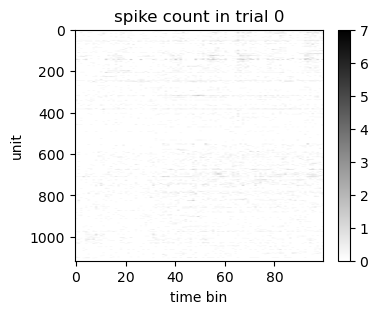

In [15]:
trial_idx = 0
plt.figure(figsize=(4,3))
plt.imshow(binned_spikes[trial_idx].T, aspect="auto", cmap="binary")
plt.title(f"spike count in trial {trial_idx}")
plt.xlabel("time bin")
plt.ylabel("unit")
plt.colorbar()

In [16]:
total_elems = binned_spikes[trial_idx].shape[0] * binned_spikes[trial_idx].shape[1]
nonzero_elems = np.count_nonzero(binned_spikes[trial_idx])
print(f"sparsity: {nonzero_elems / total_elems:.2f}")

sparsity: 0.05


In [17]:
binned_behaviors = load_trial_behaviors(one, eid, trials, allow_nans=True, **params)
binned_behaviors.keys()

dict_keys(['choice', 'block', 'reward', 'contrast', 'wheel-position', 'wheel-velocity', 'wheel-speed', 'left-whisker-motion-energy', 'right-whisker-motion-energy', 'left-pupil-diameter', 'right-pupil-diameter', 'left-camera-left-paw-speed', 'left-camera-right-paw-speed', 'right-camera-left-paw-speed', 'right-camera-right-paw-speed', 'left-nose-speed', 'right-nose-speed'])

Text(0, 0.5, 'wheel-speed')

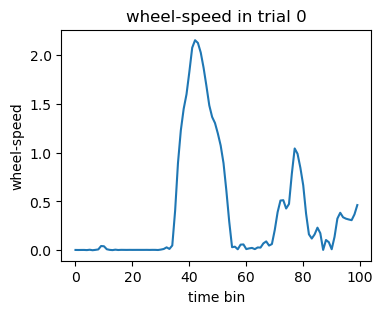

In [18]:
behave = "wheel-speed"
plt.figure(figsize=(4,3))
plt.plot(binned_behaviors[behave][trial_idx])
plt.title(f"{behave} in trial {trial_idx}")
plt.xlabel("time bin")
plt.ylabel(behave)

## Save Dataset

In [19]:
dataset = create_dataset(binned_spikes, bwm_df, idx, eid, probe, region_cluster_ids, beryl_reg, params["binsize"], binned_behaviors=None, metadata=None)
upload_dataset(dataset)

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


## Download and Test Dataset

In [20]:
dataset = download_dataset()
dataset

Generating train split: 100%|██████████| 551/551 [00:00<00:00, 1817.93 examples/s]


DatasetDict({
    train: Dataset({
        features: ['spikes_sparse_data', 'spikes_sparse_indices', 'spikes_sparse_indptr', 'spikes_sparse_shape', 'region_cluster_ids', 'brain_regions', 'bin_size', 'eid', 'probe_name', 'session_number', 'date', 'subject', 'lab'],
        num_rows: 551
    })
})

In [23]:
spikes_sparse_data_list = dataset['train']['spikes_sparse_data']
spikes_sparse_indices_list = dataset['train']['spikes_sparse_indices']
spikes_sparse_indptr_list = dataset['train']['spikes_sparse_indptr']
spikes_sparse_shape_list = dataset['train']['spikes_sparse_shape']

downloaded_binned_spikes = get_binned_spikes_from_sparse(spikes_sparse_data_list, spikes_sparse_indices_list, spikes_sparse_indptr_list, spikes_sparse_shape_list)

print(f"Shape of downloaded binned spikes: {downloaded_binned_spikes.shape}. Shape of original binned spikes: {binned_spikes.shape}")

Shape of downloaded binned spikes: (551, 100, 1116). Shape of original binned spikes: (551, 100, 1116)
